In [311]:
imgpath = 'stitched--U00--V00--C00--Z00.png'
#!wget folk.ntnu.no/seljebu/master/stitched--U00--V00--C00--Z00.png -O $imgpath

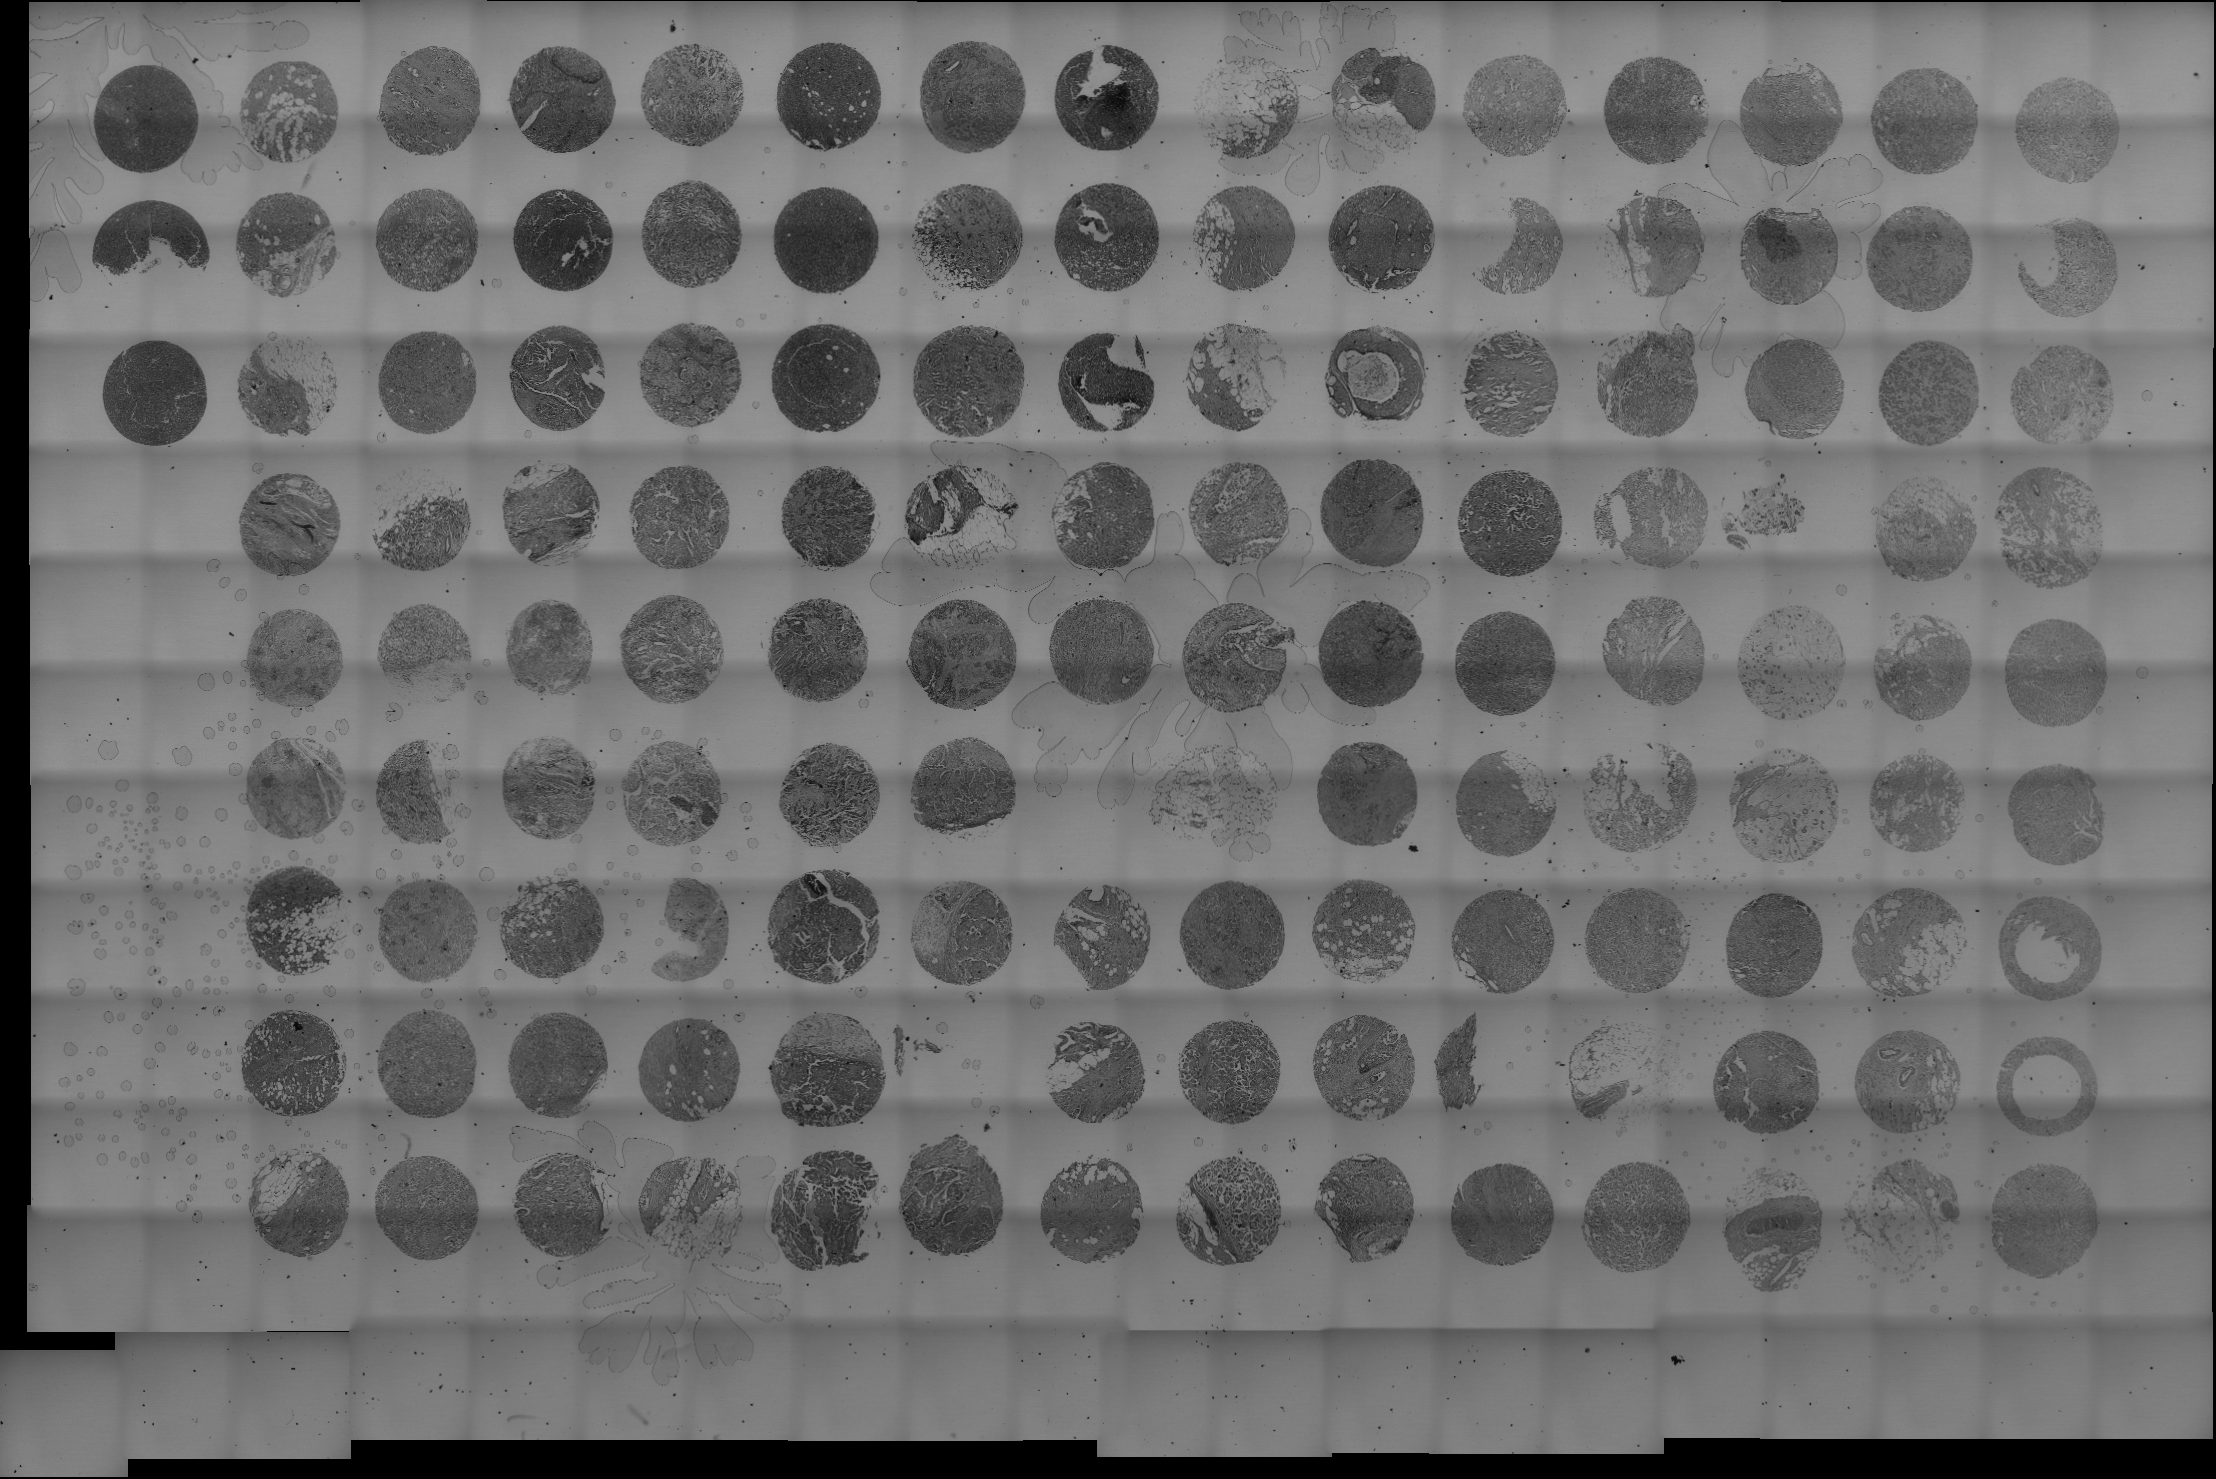

In [312]:
from IPython import display
display.Image(imgpath)

In [313]:
from skimage import io

In [314]:
img = io.imread(imgpath)

# Image processing imports

In [315]:
import skimage
from skimage import * # tools like img_as_float
from skimage import filters, exposure, morphology, feature, measure, segmentation
import scipy.ndimage as nd
import numpy as np

# Plugins

In [316]:
from skimage.viewer.plugins import base
from skimage.viewer.widgets.core import Slider, CheckBox
from skimage.viewer.canvastools import RectangleTool
from datetime import datetime

In [317]:
from skimage.viewer.qt import QtCore

class Plugin(base.Plugin):
    """override attach: link plugins together with plugin.image_changed instead
    of all listening to image_viewer.original_image_changed
    """
    
    def attach(self, image_viewer):
        self.dock = 'right'
        self.setParent(image_viewer)
        self.setWindowFlags(QtCore.Qt.Dialog)

        self.image_viewer = image_viewer
        if len(image_viewer.plugins) == 0:
            self.arguments = [image_viewer.image]
            image_viewer.original_image_changed.connect(self._update_original_image)
        else:
            self.arguments = [image_viewer.plugins[-1].arguments[0]]
            image_viewer.plugins[-1].image_changed.connect(self._update_original_image)
        
        image_viewer.plugins.append(self)
        self.filter_image()

## EnablePlugin

In [318]:
class EnablePlugin(Plugin):
    "Plugin with checkbox for enable/disable"
    def __init__(self, *args, **kwargs):
        super(EnablePlugin, self).__init__(*args, **kwargs)
        enable = CheckBox('enabled', ptype='plugin')
        self.add_widget(enable)
        self.enabled = False # self.update_plugin will update this
    
    def update_plugin(self, name, val):
        super(EnablePlugin, self).update_plugin(name,val)
        self.filter_image()

    def filter_image(self, *args, **kwargs):
        # filter if plugin enabled and we have image
        if self.enabled and len(self.arguments):
            super(EnablePlugin, self).filter_image(*args, **kwargs)
        elif len(self.arguments):
            self.display_filtered_image(self.arguments[0])
            self.image_changed.emit(self.arguments[0])

## SelemPlugin

In [319]:
class SelemPlugin(EnablePlugin):
    """Add selem size widget for filters that use selem, instead of defining a
    separate filter-function for each of them.
    """
    def __init__(self, *args, **kwargs):
        super(SelemPlugin, self).__init__(*args, **kwargs)
        size = Slider('selem', low=2, high=100, value=3, value_type='int',
                      ptype='plugin')
        self.add_widget(size)
        size.callback = self.update_selem
        self.update_selem('selem', size.val)

    def update_selem(self, name, value):
        from skimage.morphology import square
        self.keyword_arguments['selem'] = square(value)
        self.filter_image()

# Noise removal
- mean
- pop bilateral (amount in neighborhood with intensity whitin g-s0,g+s1)
- entropy

## crop

In [320]:
from skimage.viewer.qt import QtGui
from skimage.viewer.widgets.core import BaseWidget

In [321]:
class ResetWidget(BaseWidget):
    "Reset button which sets image to original_image"
    def __init__(self):
        super(ResetWidget, self).__init__(self)
        self.reset_button = QtGui.QPushButton('Reset')
        self.reset_button.clicked.connect(self.reset)

        self.layout = QtGui.QHBoxLayout(self)
        self.layout.addWidget(self.reset_button)
        
    def reset(self):
        img = self.plugin.image_viewer.original_image.copy()
        self.plugin.display_filtered_image(img)
        self.plugin.image_changed.emit(img)

In [322]:
class Crop(Plugin):
    "Crop plugin with reset button"
    name = 'Crop'
    def __init__(self, maxdist=10, **kwargs):
        super(Crop, self).__init__(**kwargs)
        self.maxdist = maxdist

    def attach(self, image_viewer):
        super(Crop, self).attach(image_viewer)
        self.rect_tool = RectangleTool(image_viewer,
                                       maxdist=self.maxdist,
                                       on_enter=self.crop)
        self.artists.append(self.rect_tool)
        self.add_widget(ResetWidget())
        
    def crop(self, extents):
        xmin, xmax, ymin, ymax = extents
        cropped = self.arguments[0][ymin:ymax+1, xmin:xmax+1]

        self.display_filtered_image(cropped)
        self.image_changed.emit(cropped)

In [323]:
crop = Crop()

## mean

In [324]:
mean = SelemPlugin(image_filter=filters.rank.mean)
mean.name = 'Mean'

## pop_bilateral

In [325]:
pop_bilateral = SelemPlugin(image_filter=filters.rank.pop_bilateral)
pop_bilateral.name = 'Pop bilateral'
pop_bilateral += Slider('s0', low=1, high=50, value=10, value_type='int')
pop_bilateral += Slider('s1', low=1, high=50, value=10, value_type='int')

## entropy

In [326]:
def entropy_filter(img, selem):
    ent = filters.rank.entropy(img, selem)
    return exposure.rescale_intensity(ent)

In [327]:
entropy = SelemPlugin(image_filter=entropy_filter)
entropy.name = 'Entropy'

# Segmentation
- otsu
- adaptive
- canny edge
- sobel
- random walker

## otsu

In [328]:
def otsu_filter(image):
    t = filters.threshold_otsu(image)
    return image >= t

In [329]:
otsu = EnablePlugin(image_filter=otsu_filter)
otsu.name = 'Otsu'

## adaptive

In [330]:
adaptive = EnablePlugin(image_filter=filters.threshold_adaptive)
adaptive.name = 'Adaptive'
adaptive += Slider('block_size', low=2, high=200, value=10, value_type='int')

## canny edge

In [331]:
canny = EnablePlugin(image_filter=feature.canny)
canny.name = 'Canny'
canny += Slider('sigma', low=0, high=100, value=5)
canny += Slider('low_threshold', low=0, high=255, value=5, value_type='int')
canny += Slider('high_threshold', low=0, high=255, value=10, value_type='int')

## sobel

In [332]:
sobel = EnablePlugin(image_filter=filters.sobel)
sobel.name = 'Sobel'

# Post segmentation
- fill holes
- opening 
- min area
- watershed
- erosion / dilation
- template match
- convex hull

## invert

In [333]:
def invert_filter(img):
    r = -img
    return exposure.rescale_intensity(r)

In [334]:
invert = EnablePlugin(image_filter=invert_filter)
invert.name = 'Invert'

## fill holes

In [335]:
def fill_holes_filter(img, selem, clear_border, zero_border, invert):
    if invert:
        img = invert_filter(img)
    cleared = img.copy()
    if zero_border:
        a = zero_border
        cleared[ :a,:] = 0
        cleared[-a:,:] = 0
        cleared[:, :a] = 0
        cleared[:,-a:] = 0
    if clear_border:
        segmentation.clear_border(cleared)
    return nd.morphology.binary_fill_holes(cleared, selem)

In [336]:
fill_holes = SelemPlugin(image_filter=fill_holes_filter)
fill_holes.name = 'Fill holes'
fill_holes += CheckBox('invert')
fill_holes += CheckBox('clear_border')
fill_holes += Slider('zero_border', low=0, high=20, value=3, value_type='int')

## erosion / dilation

In [337]:
erosion = SelemPlugin(image_filter=morphology.erosion)
erosion.name = "Erosion"

In [338]:
erosion2 = SelemPlugin(image_filter=morphology.erosion)
erosion2.name = "Erosion 2"

In [339]:
dilation = SelemPlugin(image_filter=morphology.dilation)
dilation.name = "Dilation"

## minimum area

In [340]:
def area_filter(img, size):
    labels = measure.label(img)
    counts = np.bincount(labels.ravel())
    # set background count to zero
    counts[counts.argmax()] = 0
    mask = counts > size
    return mask[labels]

In [341]:
area = EnablePlugin(image_filter=area_filter)
area.name = "Min area"
area += Slider('size', low=10,high=1e6,value=1000,value_type='int')

# Viewer

In [342]:
from skimage.viewer import viewers
from skimage.viewer.qt import Qt, QtWidgets

class ImageViewer(viewers.ImageViewer):
    "override viewer to not emit plugin._update_original_image"
    
    #copied from scikit-image
    def __add__(self, plugin):
        """Add plugin to ImageViewer"""
        plugin.attach(self)
    # do not emit 
    #    self.original_image_changed.connect(plugin._update_original_image)

        if plugin.dock:
            location = self.dock_areas[plugin.dock]
            dock_location = Qt.DockWidgetArea(location)
            dock = QtWidgets.QDockWidget()
            dock.setWidget(plugin)
            dock.setWindowTitle(plugin.name)
            self.addDockWidget(dock_location, dock)

            horiz = (self.dock_areas['left'], self.dock_areas['right'])
            dimension = 'width' if location in horiz else 'height'
            self._add_widget_size(plugin, dimension=dimension)

        return self

In [343]:
noise = ImageViewer(img)
noise.name = 'Noise'
noise += crop
noise += mean
noise += pop_bilateral
entropy.enable = True
noise += entropy

In [344]:
seg = ImageViewer(entropy)
seg += sobel
seg += canny
otsu.enabled = True
seg += otsu
seg += adaptive

In [345]:
pre_label = ImageViewer(adaptive)
pre_label += invert
pre_label += erosion
pre_label += dilation
area.enabled = True
pre_label += area
pre_label += erosion2
pre_label += fill_holes

In [346]:
#noise.show();

# find position
- compare area/circuference circle
- go to area
- calc center of mass ?
- edge -> fit circle edge

In [347]:
def label_filter(img):
    l = measure.label(img, background=0)
    if l.max() > 2**16-1:
        print('more than 2^16 labels, aborting labeling')
        return
    return color.label2rgb(l, bg_color=(0,0,0))
labels = EnablePlugin(image_filter=label_filter)
labels.name = 'Label'

In [348]:
label = ImageViewer(fill_holes)
label += labels

In [349]:
noise.show();